In [12]:
import numpy as np
from skopt import BayesSearchCV
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_digits

import os
import pandas as pd
import torch
from torch.optim import AdamW, lr_scheduler
from torch.utils.data import DataLoader
from tqdm import tqdm
from utils.data import GeneFeatureDataset, seq_concat, select_cols
from utils.model import GeneInteractionModel
from utils.loss import BalancedMSELoss

import optuna
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from itertools import combinations

pd.options.mode.chained_assignment = None  # default='warn'

In [13]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


# Create test/train splits for 5 models

In [14]:
finetune_data = pd.read_csv('../easy_prime/figure_rep/DeepPrime_ForFT_withGenes.csv')
finetune_data

,gene,ID,WT74_On,Edited74_On,PBSlen,RTlen,RT-PBSlen,Edit_pos,Edit_len,RHA_len,...,nGCcnt1,nGCcnt2,nGCcnt3,fGCcont1,fGCcont2,fGCcont3,MFE3,MFE4,DeepSpCas9_score,Measured_PE_efficiency
0,DNMT1,EDFIG5B_DNMT1_10NT,TGGGGATTCCTGGTGCCAGAAACAGGGGTGACGGGAGGGCAGAACT...,xxxxxxxxCCTGGTGCCAGAAACAGTGGTxxxxxxxxxxxxxxxxx...,13,8,21,5,1,3,...,8,4,12,61.538462,50.000000,57.142857,-1.7,-1.6,65.144363,6.410003
1,DNMT1,EDFIG5B_DNMT1_10NT,TGGGGATTCCTGGTGCCAGAAACAGGGGTGACGGGAGGGCAGAACT...,xxxxxxxxCCTGGTGCCAGAAACAGTGGTGxxxxxxxxxxxxxxxx...,13,9,22,5,1,4,...,8,5,13,61.538462,55.555556,59.090909,-1.7,-1.6,65.144363,0.919506
2,DNMT1,EDFIG5B_DNMT1_10NT,TGGGGATTCCTGGTGCCAGAAACAGGGGTGACGGGAGGGCAGAACT...,xxxxxxxxCCTGGTGCCAGAAACAGTGGTGAxxxxxxxxxxxxxxx...,13,10,23,5,1,5,...,8,5,13,61.538462,50.000000,56.521739,-1.7,-1.6,65.144363,5.100177
3,DNMT1,EDFIG5B_DNMT1_10NT,TGGGGATTCCTGGTGCCAGAAACAGGGGTGACGGGAGGGCAGAACT...,xxxxxxxxCCTGGTGCCAGAAACAGTGGTGACxxxxxxxxxxxxxx...,13,11,24,5,1,6,...,8,6,14,61.538462,54.545455,58.333333,-1.7,-1.6,65.144363,9.992335
4,DNMT1,EDFIG5B_DNMT1_10NT,TGGGGATTCCTGGTGCCAGAAACAGGGGTGACGGGAGGGCAGAACT...,xxxxxxxxCCTGGTGCCAGAAACAGTGGTGACGxxxxxxxxxxxxx...,13,12,25,5,1,7,...,8,7,15,61.538462,58.333333,60.000000,-1.7,-1.6,65.144363,3.479796
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,RNF2,FIG2A_PE2_RNF2_10,GGCAGTCATCTTAGTCATTACCTGAGGTGTTCGTTGTAACTCATAT...,xxxxxxCATCTTAGTCATTACATGAGGTGTTCxxxxxxxxxxxxxx...,15,11,26,1,1,10,...,5,5,10,33.333333,45.454545,38.461538,-1.1,0.0,52.229725,3.630080
195,RNF2,FIG2A_PE2_RNF2_10,GGCAGTCATCTTAGTCATTACCTGAGGTGTTCGTTGTAACTCATAT...,xxxxxxCATCTTAGTCATTACATGAGGTGTTCxxxxxxxxxxxxxx...,15,11,26,1,1,10,...,5,5,10,33.333333,45.454545,38.461538,-1.1,0.0,52.229725,6.989605
196,RNF2,FIG2A_PE2_RNF2_10,GGCAGTCATCTTAGTCATTACCTGAGGTGTTCGTTGTAACTCATAT...,xxxxxTCATCTTAGTCATTACATGAGGTGTTCxxxxxxxxxxxxxx...,16,11,27,1,1,10,...,5,5,10,31.250000,45.454545,37.037037,-1.6,0.0,52.229725,3.022388
197,RNF2,FIG2A_PE2_RNF2_10,GGCAGTCATCTTAGTCATTACCTGAGGTGTTCGTTGTAACTCATAT...,xxxxGTCATCTTAGTCATTACATGAGGTGTTCxxxxxxxxxxxxxx...,17,11,28,1,1,10,...,6,5,11,35.294118,45.454545,39.285714,-1.5,0.0,52.229725,2.146368


### At the end of this section, you have 5 different splits of test/train data. In each of the test sets, there is roughly equal representation across all the 8 genes. Additionally, if you concatenate all the test sets together across all 5 models, you will get all the 199 points. Additionally, each test/train pair contains all 199 points.

In [24]:
# genes = ['RNF2', 'EMX1', 'VEGFA', 'HEK3', 'FANCF', 'DNMT1', 'HEK4', 'RUNX1']
# gene_indices = {}

# # Iterate through the dataset to collect gene indices
# for index, row in finetune_data.iterrows():
#     gene_name = row['gene']
    
#     # If gene name is already in the dictionary, append index to its list
#     if gene_name in gene_indices:
#         gene_indices[gene_name].append(index)
#     # Otherwise, create a new entry with gene name as key and list containing index as value
#     else:
#         gene_indices[gene_name] = [index]

# # Print the gene_indices dictionary
# print(gene_indices)

{'DNMT1': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23], 'EMX1': [24, 50, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 93, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 177], 'HEK3': [25, 49, 77, 92, 142, 144, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176], 'FANCF': [26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 51, 52, 78, 91, 143], 'VEGFA': [53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76], 'RNF2': [79, 155, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198], 'HEK4': [94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117], 'RUNX1': [118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141]}


In [32]:
gene_indices = {'RNF2': [79, 155, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198], 'EMX1': [24, 50, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 93, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 177], 'VEGFA': [53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76], 'HEK3': [25, 49, 77, 92, 142, 144, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176], 'FANCF': [26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 51, 52, 78, 91, 143], 'DNMT1': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23], 'HEK4': [94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117], 'RUNX1': [118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141]}

In [33]:
np.random.seed(42)

# Define the number of splits
num_splits = 5

# Initialize StratifiedKFold to ensure balanced splitting
skf = StratifiedKFold(n_splits=num_splits, shuffle=True, random_state=42)

# Combine all gene indices into a single list
all_gene_indices = np.concatenate(list(gene_indices.values()))


# Create labels for each gene based on their indices
gene_labels = np.zeros(len(all_gene_indices))
for i, gene_name in enumerate(gene_indices.keys()):
    gene_labels[gene_indices[gene_name]] = i

# List to store train/test splits
train_test_splits = []

# Iterate over the splits
for train_index, test_index in skf.split(all_gene_indices, gene_labels):
    # Initialize lists to store indices for train and test sets
    train_indices = []
    test_indices = []
    
    # Split each gene's data separately
    for gene_name, indices in gene_indices.items():
        
        # Divide the indices into train and test sets
        gene_train_index = np.intersect1d(train_index, indices)
        gene_test_index = np.intersect1d(test_index, indices)
        
        # Add the indices to the respective lists
        train_indices.extend(gene_train_index)
        test_indices.extend(gene_test_index)
    
    # Shuffle the indices
    np.random.shuffle(train_indices)
    np.random.shuffle(test_indices)
    
    num_validation_indices = int(0.1 * len(train_indices))                                            # I want 10% of the indices to be used for validation
    validation_indices = np.random.choice(train_indices, size=num_validation_indices, replace=False)  # Randomly choose 10% of the indices for validation
    train_indices = [index for index in train_indices if index not in validation_indices]             # Remove validation indices from train_indices
    

    # Append the train/test indices split to the list
    train_test_splits.append((train_indices, validation_indices, test_indices))
    print(len(train_indices), len(validation_indices), len(test_indices))


144 15 40
144 15 40
144 15 40
144 15 40
144 16 39


### Now, for each test/train index split up, I need to:

### - Take 10% of the test data for validation
### - Create x_train, g_train, and y_train
### - Create x_val, g_val, and y_val
### - Create x_test, g_test, and y_test

In [34]:
def get_wrapper(split, num_model):
    
    # Train and test
    train_indices = split[0]
    validation_indices = split[1]
    test_indices = split[2]
    
    #Prepare train
    x_train, g_train, y_train = get_training(finetune_data, train_indices, num_model)
    
    #Prepare validation
    x_validation, g_validation, y_validation = get_validation(finetune_data, validation_indices, num_model)
    
    #Prepare test
    x_test, g_test, y_test = get_testing(finetune_data, test_indices, num_model)
    
    return (x_train, g_train, y_train, x_validation, g_validation, y_validation, x_test, g_test, y_test)
    

In [35]:
def get_training(dataset, train_indices, num_model):
    
    gene_path_train = 'data/genes/' + 'endogenous_train_' + str(num_model) + '.npy'
    
    train_dataset = finetune_data.loc[train_indices]
    train_dataset = train_dataset.reset_index(drop = True)  #Need to reset indices so it doesn't throw an error


    if not os.path.isfile(gene_path_train):
        g_train = seq_concat(train_dataset)
        np.save(gene_path_train, g_train)
    else:
        g_train = np.load(gene_path_train)


    train_features, train_target = select_cols(train_dataset)  #Trained target features 
    train_type = train_dataset.loc[:, ['type_sub', 'type_ins', 'type_del']]

    mean = pd.read_csv('data/mean.csv', header=None, index_col=0)
    std = pd.read_csv('data/std.csv', header=None, index_col=0)

    mean = mean.squeeze('columns')
    std= std.squeeze('columns')

    x_train = (train_features - mean) / std
    y_train = train_target
    y_train = pd.concat([y_train, train_type], axis=1)

    g_train = torch.tensor(g_train, dtype=torch.float32, device=device)
    x_train = torch.tensor(x_train.to_numpy(), dtype=torch.float32, device=device)
    y_train = torch.tensor(y_train.to_numpy(), dtype=torch.float32, device=device)
    
    return([x_train, g_train, y_train])

In [36]:
def get_validation(dataset, validation_indices, num_model):
    
    gene_path_validation = 'data/genes/' + 'endogenous_val_' + str(num_model) + '.npy'
    
    validation_dataset = finetune_data.loc[validation_indices]
    validation_dataset = validation_dataset.reset_index(drop = True)  #Need to reset indices so it doesn't throw an error


    if not os.path.isfile(gene_path_validation):
        g_validation = seq_concat(validation_dataset)
        np.save(gene_path_validation, g_validation)
    else:
        g_validation = np.load(gene_path_validation)


    validation_features, validation_target = select_cols(validation_dataset)  
    validation_type = validation_dataset.loc[:, ['type_sub', 'type_ins', 'type_del']]

    mean = pd.read_csv('data/mean.csv', header=None, index_col=0)
    std = pd.read_csv('data/std.csv', header=None, index_col=0)

    mean = mean.squeeze('columns')
    std= std.squeeze('columns')

    x_validation = (validation_features - mean) / std
    y_validation = validation_target
    y_validation = pd.concat([y_validation, validation_type], axis=1)

    g_validation = torch.tensor(g_validation, dtype=torch.float32, device=device)
    x_validation = torch.tensor(x_validation.to_numpy(), dtype=torch.float32, device=device)
    y_validation = torch.tensor(y_validation.to_numpy(), dtype=torch.float32, device=device)
    
    return([x_validation, g_validation, y_validation])

In [37]:
def get_testing(dataset, test_indices, num_model):
    

    gene_path_test = 'data/genes/' + 'endogenous_test' +  str(num_model) +'.npy'
    
    test_dataset = finetune_data.loc[test_indices]
    test_dataset = test_dataset.reset_index(drop = True)  #Need to reset indices so it doesn't throw an error

    if not os.path.isfile(gene_path_test):
        g_test = seq_concat(test_dataset)
        np.save(gene_path_test, g_test)
    else:
        g_test = np.load(gene_path_test)

    test_features, test_target = select_cols(test_dataset)  #Test target features 
    test_type = test_dataset.loc[:, ['type_sub', 'type_ins', 'type_del']]

    mean = pd.read_csv('data/mean.csv', header=None, index_col=0)
    std = pd.read_csv('data/std.csv', header=None, index_col=0)

    mean = mean.squeeze('columns')
    std= std.squeeze('columns')

    x_test = (test_features - mean) / std
    y_test = test_target
    y_test = pd.concat([y_test, test_type], axis=1)

    g_test = torch.tensor(g_test, dtype=torch.float32, device=device)
    x_test = torch.tensor(x_test.to_numpy(), dtype=torch.float32, device=device)
    y_test = torch.tensor(y_test.to_numpy(), dtype=torch.float32, device=device)
    
    return([x_test, g_test, y_test])

# Hyperparameter Optimization

In [38]:
import torch
import torch.optim as optim
import numpy as np
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import optuna
import time
from optuna.trial import TrialState

In [39]:
class Optuna_Trainer:
    
    # Initializing attributes including training and testing sets g (one-hot encoding of input sequences), x (features), and y (Measured editing efficiencies).
    def __init__(self, model, x_train, g_train, y_train, x_y_validation, g_y_validation, y_validation): 
        self.g_train = g_train   # Training data for g
        self.x_train = x_train   # Training data for x 
        self.y_train = y_train   # Training data for y
        self.g_val = g_validation       # Validation data for g
        self.x_val = x_validation       # Validation data for x
        self.y_val = y_validation       # Validation data for y
        self.model = model       # Call machine learning model as an attribute of the object
        self.lr = 1e-5           # Learning rate
        self.wd = 1e-5           # Weight decay: Weight decay should typically be same value as the learning rate
        self.bs = 8              # Batch size 
        self.ep = 100            # Number of epochs
        
        # Patience represents the number of consecutive trials where the validation loss does not decrease (performance is not improved).
        self.patience = 20       # Changing patience value to 20. 
        self.delta = 1e-4        # Delta is the threshold needed for the difference between the previous minimum loss and the validation loss.

    # Set up hyperparameter search space
    def setup_trials(self, trial):
        
        #Parameters that need to be searched
        self.lr = trial.suggest_categorical("lr", [1e-4,1e-3,2e-3,5e-3, 1e-2])   # Categorical values for learning rate
        self.wd = self.lr                                                        # Assign weight decay to be the same as the learning rate
        self.bs = trial.suggest_categorical("batch_size", [8, 16, 32])           # Categorical values for batch size
        self.ep = trial.suggest_categorical("num_epochs", [50, 100, 200, 500])   # Categorical values for number of epochs
        
        # Fixed parameters
        self.hs = 128                    # Hidden size
        self.nl = 1                      # Number of GRU layers
        self.schedule = True             # Learning rate scheduler
        
        # Print trial hyperparameters
        for key, value in trial.params.items():
            print("{}: {}".format(key, value))
    
    # Trains the DeepPrime model based on the provided testing and training data
    def train_model(self, trial): 
        
        min_loss = None                   #  Stores the minimum loss, initialize with no value
        early_stopping_counter = 0        #  Track how many consecutive epochs have occurred without improvement in the validation loss, used to prevent overfitting.

        #Trial object is created when Optuna generates a study object, so it's not something to explicitly point to
        self.setup_trials(trial) # Sets up the trial with a set of hyperparameters derived from the setup_trials function


        # Prepare the training data to run through the model
        train_dataset = GeneFeatureDataset(self.g_train, self.x_train, self.y_train) 
        train_loader = DataLoader(train_dataset, batch_size=self.bs, shuffle=True, drop_last=True) 

        # Prepare the testing and validation datasets
        val_dataset = GeneFeatureDataset(self.g_val, self.x_val, self.y_val) 
        val_loader = DataLoader(val_dataset, batch_size=self.bs, shuffle=True) # Q: Shuffle?

        optimizer = optim.AdamW(self.model.parameters(), lr=self.lr, weight_decay=self.wd)   # Sets up optimizer, I am also using AdamW
        optimizer.zero_grad()  # Zeroes out gradients, kind of a "hack" where optimization is actually better when gradients are not stored
        
        criterion = BalancedMSELoss() # Loss function used in DeepPrime

        # print("epoch\ttrain_corr\ttrain_loss\ttrue_auc\tpred_auc\tval_corr\tval_loss\telapsed_time")
        for epoch in range(self.ep): # self.ep is the number of epochs, so here we are iterating through the epochs
            
            # Train
            self.model.train()  # Sets model in training mode. Make sure to use self.model because model is now an attribute of the class itself.
            
            train_loss = []    # List that will keep track of the loss across the entire epoch
            train_count = 0    # Number of samples processed in epoch
    

            # Works through each batch of data set up by the train_loader
            for i, (g_batch, x_batch, y_batch) in enumerate(train_loader):
                g_batch, x_batch, y_batch = g_batch.cuda(), x_batch.cuda(), y_batch.cuda() # We are on GPU, so move tensors to GPU

                # Update values for all three tensors. Following permutations used in DeepPrime.
                g_batch = g_batch.permute((0, 3, 1, 2))
                x_batch = x_batch
                y_batch = y_batch.reshape(-1, 4)


                optimizer.zero_grad()  #Zero out gradient for each batch

                output = self.model(g_batch, x_batch) # Send g and x through the model

                total_loss = criterion(output, y_batch) # Calculate the loss between the model output and the actual measured efficiencies

                total_loss.backward() # Computes gradients of the loss with repsect to the model parameters
                optimizer.step()  # Applies optimization to update parameters

                train_loss.append(x_batch.size(0) * total_loss.detach().cpu().numpy()) # Multiplies batch-loss by batch size to normalize for different sized batches during training
                train_count += x_batch.size(0)  # Updates number of samples processed in the epoch

            train_loss = sum(train_loss) / train_count  # train_loss now represents the average training loss across batches for the ENTIRE epoch


            # Validation
            self.model.eval()  # Set model in evaluation mode
            
            val_loss = []
            val_count = 0

            # Same as with training batches
            for i, (g_batch, x_batch, y_batch) in enumerate(val_loader):
                g_batch, x_batch, y_batch = g_batch.cuda(), x_batch.cuda(), y_batch.cuda()

                g_batch = g_batch.permute((0, 3, 1, 2))
                x_batch = x_batch
                y_batch = y_batch.reshape(-1, 4)
                
                output = self.model(g_batch, x_batch)  #Run validation data through model

                loss = criterion(output, y_batch)
                
                
                val_loss.append(x_batch.size(0) * loss.detach().cpu().numpy())
                val_count += x_batch.size(0)

            val_loss = sum(val_loss) / val_count


            # Summary of training progress
            # print("{}\t{:.4f}\t{:.4f}".format(epoch, train_loss, val_loss))

            trial.report(val_loss, epoch) # Reports the result of the current epoch to Optuna, so Optuna can keep track of model performance throughout the trial.
            

            if min_loss is None:
                min_loss = val_loss  
            elif min_loss - val_loss > self.delta:                    # If the difference between the previous minimum loss and the current validation loss is greater than delta, update values
                min_loss = val_loss                                   # Set the new minimum loss to current validation loss
                early_stopping_counter = 0                            # Reset to 0, indicating no consecutive epochs with increasing validation loss.
            elif min_loss - val_loss < self.delta:                    # No improvement in validation loss
                early_stopping_counter += 1                           # Consecutive epoch for which there is no improvement on validation loss
                if early_stopping_counter >= self.patience:           # At this point, further training is unlikely to improve/lower validation loss, so break
                    break

        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

        return val_loss # #Returns the loss across the epochs, as this is the value we want to minimize

    def exec_study(self):
        study = optuna.create_study()                      # Creates Optuna study object, maximizing correlation
        study.optimize(self.train_model, n_trials=30)      # Runs train_model function n_trials times
        return self.print_result(study)                    # Prints out hyperparameters used for combination that generated lowest validation loss.
    
    def print_result(self, study):
        pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
        complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

        print("Study statistics:")
        print("Number of finished trials:", len(study.trials))
        print("Number of pruned trials:", len(pruned_trials))
        print("Number of complete trials:", len(complete_trials))

        print("Best trial:")
        best_trial = study.best_trial

        print("Value: ", best_trial.value)

        best_params = {}
        print("Params:")
        for key, value in best_trial.params.items():
            print("{}: {}".format(key, value))
            best_params[key] = value
        for key, value in best_trial.user_attrs.items():
            print("{}: {}".format(key, value))
            best_params[key] = value

        return best_params


In [214]:
# Run Optuna_Trainer

n_models = 5

for m in range(n_models):
    print(f"Training Model {m}")
    
    #Get the necessary information
    split = train_test_splits[m]   #There are the same number of splits as there are models
    x_train, g_train, y_train, x_validation, g_validation, y_validation, x_test, g_test, y_test = get_wrapper(split, m)
    
    
    # Set random seed
    random_seed = m
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    np.random.seed(random_seed)
    
    print(device)

    # Load pre-trained model
    model = GeneInteractionModel(hidden_size=128, num_layers=1).to(device)  # Model
    model.load_state_dict(torch.load('models/ontarget/final/model_{}.pt'.format(m % 5)))  # Loads weights, biases from this pre-trained model

    # Create a Trainer instance for each model
    trainer = Optuna_Trainer(model, x_train, g_train, y_train, x_validation, g_validation, y_validation)

    # Execute hyperparameter study
    trainer.exec_study()

    print(f"Model {m} complete.")

Training Model 0
cuda:0


[I 2024-02-26 16:09:16,513] A new study created in memory with name: no-name-c20b97a5-dfbb-4dab-96c6-12d43d4e6763


lr: 0.0001
batch_size: 8
num_epochs: 200


[I 2024-02-26 16:09:37,743] Trial 0 finished with value: 1.1988555431365966 and parameters: {'lr': 0.0001, 'batch_size': 8, 'num_epochs': 200}. Best is trial 0 with value: 1.1988555431365966.


lr: 0.01
batch_size: 16
num_epochs: 200


[I 2024-02-26 16:09:41,212] Trial 1 finished with value: 0.21060101687908173 and parameters: {'lr': 0.01, 'batch_size': 16, 'num_epochs': 200}. Best is trial 1 with value: 0.21060101687908173.


lr: 0.002
batch_size: 16
num_epochs: 50


[I 2024-02-26 16:09:42,525] Trial 2 finished with value: 0.2966647744178772 and parameters: {'lr': 0.002, 'batch_size': 16, 'num_epochs': 50}. Best is trial 1 with value: 0.21060101687908173.


lr: 0.001
batch_size: 8
num_epochs: 50


[I 2024-02-26 16:09:46,399] Trial 3 finished with value: 0.275040528178215 and parameters: {'lr': 0.001, 'batch_size': 8, 'num_epochs': 50}. Best is trial 1 with value: 0.21060101687908173.


lr: 0.001
batch_size: 8
num_epochs: 100


[I 2024-02-26 16:09:50,436] Trial 4 finished with value: 0.3810619672139486 and parameters: {'lr': 0.001, 'batch_size': 8, 'num_epochs': 100}. Best is trial 1 with value: 0.21060101687908173.


lr: 0.01
batch_size: 32
num_epochs: 100


[I 2024-02-26 16:09:51,368] Trial 5 finished with value: 0.42140257358551025 and parameters: {'lr': 0.01, 'batch_size': 32, 'num_epochs': 100}. Best is trial 1 with value: 0.21060101687908173.


lr: 0.005
batch_size: 16
num_epochs: 100


[I 2024-02-26 16:09:53,356] Trial 6 finished with value: 0.3801342844963074 and parameters: {'lr': 0.005, 'batch_size': 16, 'num_epochs': 100}. Best is trial 1 with value: 0.21060101687908173.


lr: 0.005
batch_size: 32
num_epochs: 50


[I 2024-02-26 16:09:54,109] Trial 7 finished with value: 0.40259143710136414 and parameters: {'lr': 0.005, 'batch_size': 32, 'num_epochs': 50}. Best is trial 1 with value: 0.21060101687908173.


lr: 0.002
batch_size: 8
num_epochs: 50


[I 2024-02-26 16:09:58,014] Trial 8 finished with value: 0.3713065574566523 and parameters: {'lr': 0.002, 'batch_size': 8, 'num_epochs': 50}. Best is trial 1 with value: 0.21060101687908173.


lr: 0.005
batch_size: 16
num_epochs: 200


[I 2024-02-26 16:09:59,317] Trial 9 finished with value: 0.4220978617668152 and parameters: {'lr': 0.005, 'batch_size': 16, 'num_epochs': 200}. Best is trial 1 with value: 0.21060101687908173.


lr: 0.01
batch_size: 16
num_epochs: 500


[I 2024-02-26 16:10:01,072] Trial 10 finished with value: 0.45058533549308777 and parameters: {'lr': 0.01, 'batch_size': 16, 'num_epochs': 500}. Best is trial 1 with value: 0.21060101687908173.


lr: 0.001
batch_size: 8
num_epochs: 200


[I 2024-02-26 16:10:05,318] Trial 11 finished with value: 0.3608455667893092 and parameters: {'lr': 0.001, 'batch_size': 8, 'num_epochs': 200}. Best is trial 1 with value: 0.21060101687908173.


lr: 0.01
batch_size: 16
num_epochs: 500


[I 2024-02-26 16:10:09,904] Trial 12 finished with value: 0.5076001286506653 and parameters: {'lr': 0.01, 'batch_size': 16, 'num_epochs': 500}. Best is trial 1 with value: 0.21060101687908173.


lr: 0.001
batch_size: 8
num_epochs: 50


[I 2024-02-26 16:10:15,128] Trial 13 pruned. 


lr: 0.0001
batch_size: 32
num_epochs: 200


[I 2024-02-26 16:10:16,348] Trial 14 pruned. 


lr: 0.01
batch_size: 16
num_epochs: 50


[I 2024-02-26 16:10:17,956] Trial 15 finished with value: 0.36360517144203186 and parameters: {'lr': 0.01, 'batch_size': 16, 'num_epochs': 50}. Best is trial 1 with value: 0.21060101687908173.


lr: 0.001
batch_size: 8
num_epochs: 200


[I 2024-02-26 16:10:20,623] Trial 16 finished with value: 0.4065647085507711 and parameters: {'lr': 0.001, 'batch_size': 8, 'num_epochs': 200}. Best is trial 1 with value: 0.21060101687908173.


lr: 0.01
batch_size: 8
num_epochs: 500


[I 2024-02-26 16:10:26,682] Trial 17 finished with value: 0.2679513196150462 and parameters: {'lr': 0.01, 'batch_size': 8, 'num_epochs': 500}. Best is trial 1 with value: 0.21060101687908173.


lr: 0.01
batch_size: 16
num_epochs: 500


[I 2024-02-26 16:10:28,042] Trial 18 finished with value: 0.5522788166999817 and parameters: {'lr': 0.01, 'batch_size': 16, 'num_epochs': 500}. Best is trial 1 with value: 0.21060101687908173.


lr: 0.01
batch_size: 32
num_epochs: 500


[I 2024-02-26 16:10:29,011] Trial 19 finished with value: 0.37028729915618896 and parameters: {'lr': 0.01, 'batch_size': 32, 'num_epochs': 500}. Best is trial 1 with value: 0.21060101687908173.


lr: 0.01
batch_size: 8
num_epochs: 500


[I 2024-02-26 16:10:35,080] Trial 20 finished with value: 0.30414826075236 and parameters: {'lr': 0.01, 'batch_size': 8, 'num_epochs': 500}. Best is trial 1 with value: 0.21060101687908173.


lr: 0.001
batch_size: 8
num_epochs: 500


[I 2024-02-26 16:10:37,747] Trial 21 finished with value: 0.3941822052001953 and parameters: {'lr': 0.001, 'batch_size': 8, 'num_epochs': 500}. Best is trial 1 with value: 0.21060101687908173.


lr: 0.01
batch_size: 8
num_epochs: 200


[I 2024-02-26 16:10:42,524] Trial 22 finished with value: 0.1986317257086436 and parameters: {'lr': 0.01, 'batch_size': 8, 'num_epochs': 200}. Best is trial 22 with value: 0.1986317257086436.


lr: 0.01
batch_size: 8
num_epochs: 200


[I 2024-02-26 16:10:45,075] Trial 23 finished with value: 0.2824838598569234 and parameters: {'lr': 0.01, 'batch_size': 8, 'num_epochs': 200}. Best is trial 22 with value: 0.1986317257086436.


lr: 0.01
batch_size: 8
num_epochs: 200


[I 2024-02-26 16:10:49,855] Trial 24 finished with value: 0.23869835138320922 and parameters: {'lr': 0.01, 'batch_size': 8, 'num_epochs': 200}. Best is trial 22 with value: 0.1986317257086436.


lr: 0.01
batch_size: 16
num_epochs: 200


[I 2024-02-26 16:10:51,226] Trial 25 finished with value: 0.25236040353775024 and parameters: {'lr': 0.01, 'batch_size': 16, 'num_epochs': 200}. Best is trial 22 with value: 0.1986317257086436.


lr: 0.0001
batch_size: 8
num_epochs: 200


[I 2024-02-26 16:10:54,249] Trial 26 finished with value: 0.27672207951545713 and parameters: {'lr': 0.0001, 'batch_size': 8, 'num_epochs': 200}. Best is trial 22 with value: 0.1986317257086436.


lr: 0.01
batch_size: 8
num_epochs: 200


[I 2024-02-26 16:10:59,518] Trial 27 finished with value: 0.3432760119438171 and parameters: {'lr': 0.01, 'batch_size': 8, 'num_epochs': 200}. Best is trial 22 with value: 0.1986317257086436.


lr: 0.002
batch_size: 32
num_epochs: 200


[I 2024-02-26 16:11:00,306] Trial 28 finished with value: 0.4047876000404358 and parameters: {'lr': 0.002, 'batch_size': 32, 'num_epochs': 200}. Best is trial 22 with value: 0.1986317257086436.


lr: 0.0001
batch_size: 16
num_epochs: 200


[I 2024-02-26 16:11:02,548] Trial 29 pruned. 
[I 2024-02-26 16:11:02,741] A new study created in memory with name: no-name-822cbfae-5685-473f-827a-1aa4467cfd66


Study statistics:
Number of finished trials: 30
Number of pruned trials: 3
Number of complete trials: 27
Best trial:
Value:  0.1986317257086436
Params:
lr: 0.01
batch_size: 8
num_epochs: 200
Model 0 complete.
Training Model 1
cuda:0
lr: 0.001
batch_size: 16
num_epochs: 500


[I 2024-02-26 16:11:06,423] Trial 0 finished with value: 0.7866350412368774 and parameters: {'lr': 0.001, 'batch_size': 16, 'num_epochs': 500}. Best is trial 0 with value: 0.7866350412368774.


lr: 0.002
batch_size: 32
num_epochs: 200


[I 2024-02-26 16:11:09,295] Trial 1 finished with value: 0.3230607211589813 and parameters: {'lr': 0.002, 'batch_size': 32, 'num_epochs': 200}. Best is trial 1 with value: 0.3230607211589813.


lr: 0.005
batch_size: 16
num_epochs: 200


[I 2024-02-26 16:11:11,599] Trial 2 finished with value: 0.27430015802383423 and parameters: {'lr': 0.005, 'batch_size': 16, 'num_epochs': 200}. Best is trial 2 with value: 0.27430015802383423.


lr: 0.001
batch_size: 16
num_epochs: 100


[I 2024-02-26 16:11:13,712] Trial 3 finished with value: 0.23788751661777496 and parameters: {'lr': 0.001, 'batch_size': 16, 'num_epochs': 100}. Best is trial 3 with value: 0.23788751661777496.


lr: 0.005
batch_size: 16
num_epochs: 500


[I 2024-02-26 16:11:15,149] Trial 4 finished with value: 0.2948352098464966 and parameters: {'lr': 0.005, 'batch_size': 16, 'num_epochs': 500}. Best is trial 3 with value: 0.23788751661777496.


lr: 0.0001
batch_size: 32
num_epochs: 500


[I 2024-02-26 16:11:17,164] Trial 5 finished with value: 0.18866918981075287 and parameters: {'lr': 0.0001, 'batch_size': 32, 'num_epochs': 500}. Best is trial 5 with value: 0.18866918981075287.


lr: 0.01
batch_size: 16
num_epochs: 500


[I 2024-02-26 16:11:19,560] Trial 6 finished with value: 0.2558642327785492 and parameters: {'lr': 0.01, 'batch_size': 16, 'num_epochs': 500}. Best is trial 5 with value: 0.18866918981075287.


lr: 0.01
batch_size: 16
num_epochs: 50


[I 2024-02-26 16:11:21,863] Trial 7 finished with value: 0.255921334028244 and parameters: {'lr': 0.01, 'batch_size': 16, 'num_epochs': 50}. Best is trial 5 with value: 0.18866918981075287.


lr: 0.0001
batch_size: 16
num_epochs: 500


[I 2024-02-26 16:11:24,038] Trial 8 finished with value: 0.23674340546131134 and parameters: {'lr': 0.0001, 'batch_size': 16, 'num_epochs': 500}. Best is trial 5 with value: 0.18866918981075287.


lr: 0.001
batch_size: 16
num_epochs: 500


[I 2024-02-26 16:11:26,217] Trial 9 finished with value: 0.2001221776008606 and parameters: {'lr': 0.001, 'batch_size': 16, 'num_epochs': 500}. Best is trial 5 with value: 0.18866918981075287.


lr: 0.0001
batch_size: 32
num_epochs: 50


[I 2024-02-26 16:11:27,426] Trial 10 finished with value: 0.21434679627418518 and parameters: {'lr': 0.0001, 'batch_size': 32, 'num_epochs': 50}. Best is trial 5 with value: 0.18866918981075287.


lr: 0.001
batch_size: 8
num_epochs: 500


[I 2024-02-26 16:11:30,009] Trial 11 finished with value: 0.276794175306956 and parameters: {'lr': 0.001, 'batch_size': 8, 'num_epochs': 500}. Best is trial 5 with value: 0.18866918981075287.


lr: 0.0001
batch_size: 32
num_epochs: 100


[I 2024-02-26 16:11:31,215] Trial 12 finished with value: 0.22894124686717987 and parameters: {'lr': 0.0001, 'batch_size': 32, 'num_epochs': 100}. Best is trial 5 with value: 0.18866918981075287.


lr: 0.002
batch_size: 8
num_epochs: 500


[I 2024-02-26 16:11:34,840] Trial 13 finished with value: 0.33048041462898253 and parameters: {'lr': 0.002, 'batch_size': 8, 'num_epochs': 500}. Best is trial 5 with value: 0.18866918981075287.


lr: 0.001
batch_size: 32
num_epochs: 500


[I 2024-02-26 16:11:36,653] Trial 14 finished with value: 0.20489643514156342 and parameters: {'lr': 0.001, 'batch_size': 32, 'num_epochs': 500}. Best is trial 5 with value: 0.18866918981075287.


lr: 0.0001
batch_size: 32
num_epochs: 500


[I 2024-02-26 16:11:37,872] Trial 15 finished with value: 0.2049364447593689 and parameters: {'lr': 0.0001, 'batch_size': 32, 'num_epochs': 500}. Best is trial 5 with value: 0.18866918981075287.


lr: 0.001
batch_size: 8
num_epochs: 50


[I 2024-02-26 16:11:41,311] Trial 16 finished with value: 0.21937991976737975 and parameters: {'lr': 0.001, 'batch_size': 8, 'num_epochs': 50}. Best is trial 5 with value: 0.18866918981075287.


lr: 0.0001
batch_size: 32
num_epochs: 200


[I 2024-02-26 16:11:42,606] Trial 17 finished with value: 0.20962265133857727 and parameters: {'lr': 0.0001, 'batch_size': 32, 'num_epochs': 200}. Best is trial 5 with value: 0.18866918981075287.


lr: 0.01
batch_size: 32
num_epochs: 100


[I 2024-02-26 16:11:44,083] Trial 18 finished with value: 0.13790684938430786 and parameters: {'lr': 0.01, 'batch_size': 32, 'num_epochs': 100}. Best is trial 18 with value: 0.13790684938430786.


lr: 0.01
batch_size: 32
num_epochs: 100


[I 2024-02-26 16:11:44,752] Trial 19 finished with value: 0.12963810563087463 and parameters: {'lr': 0.01, 'batch_size': 32, 'num_epochs': 100}. Best is trial 19 with value: 0.12963810563087463.


lr: 0.01
batch_size: 32
num_epochs: 100


[I 2024-02-26 16:11:45,426] Trial 20 finished with value: 0.13604867458343506 and parameters: {'lr': 0.01, 'batch_size': 32, 'num_epochs': 100}. Best is trial 19 with value: 0.12963810563087463.


lr: 0.01
batch_size: 32
num_epochs: 100


[I 2024-02-26 16:11:46,631] Trial 21 finished with value: 0.19182689487934113 and parameters: {'lr': 0.01, 'batch_size': 32, 'num_epochs': 100}. Best is trial 19 with value: 0.12963810563087463.


lr: 0.01
batch_size: 32
num_epochs: 100


[I 2024-02-26 16:11:47,331] Trial 22 finished with value: 0.11764371395111084 and parameters: {'lr': 0.01, 'batch_size': 32, 'num_epochs': 100}. Best is trial 22 with value: 0.11764371395111084.


lr: 0.01
batch_size: 32
num_epochs: 100


[I 2024-02-26 16:11:47,999] Trial 23 finished with value: 0.14245808124542236 and parameters: {'lr': 0.01, 'batch_size': 32, 'num_epochs': 100}. Best is trial 22 with value: 0.11764371395111084.


lr: 0.01
batch_size: 32
num_epochs: 100


[I 2024-02-26 16:11:48,758] Trial 24 finished with value: 0.1247195154428482 and parameters: {'lr': 0.01, 'batch_size': 32, 'num_epochs': 100}. Best is trial 22 with value: 0.11764371395111084.


lr: 0.01
batch_size: 32
num_epochs: 100


[I 2024-02-26 16:11:49,515] Trial 25 finished with value: 0.12132792919874191 and parameters: {'lr': 0.01, 'batch_size': 32, 'num_epochs': 100}. Best is trial 22 with value: 0.11764371395111084.


lr: 0.01
batch_size: 32
num_epochs: 100


[I 2024-02-26 16:11:50,832] Trial 26 finished with value: 0.1676846593618393 and parameters: {'lr': 0.01, 'batch_size': 32, 'num_epochs': 100}. Best is trial 22 with value: 0.11764371395111084.


lr: 0.01
batch_size: 8
num_epochs: 100


[I 2024-02-26 16:11:57,884] Trial 27 finished with value: 0.19068645785252253 and parameters: {'lr': 0.01, 'batch_size': 8, 'num_epochs': 100}. Best is trial 22 with value: 0.11764371395111084.


lr: 0.01
batch_size: 32
num_epochs: 100


[I 2024-02-26 16:11:58,949] Trial 28 finished with value: 0.16213050484657288 and parameters: {'lr': 0.01, 'batch_size': 32, 'num_epochs': 100}. Best is trial 22 with value: 0.11764371395111084.


lr: 0.002
batch_size: 32
num_epochs: 100


[I 2024-02-26 16:12:00,832] Trial 29 finished with value: 0.16979245841503143 and parameters: {'lr': 0.002, 'batch_size': 32, 'num_epochs': 100}. Best is trial 22 with value: 0.11764371395111084.


Study statistics:
Number of finished trials: 30
Number of pruned trials: 0
Number of complete trials: 30
Best trial:
Value:  0.11764371395111084
Params:
lr: 0.01
batch_size: 32
num_epochs: 100
Model 1 complete.
Training Model 2
cuda:0


[I 2024-02-26 16:12:01,060] A new study created in memory with name: no-name-27d22b8b-a33a-471d-a6c5-314734188908


lr: 0.002
batch_size: 16
num_epochs: 100


[I 2024-02-26 16:12:06,678] Trial 0 finished with value: 0.5663038492202759 and parameters: {'lr': 0.002, 'batch_size': 16, 'num_epochs': 100}. Best is trial 0 with value: 0.5663038492202759.


lr: 0.0001
batch_size: 16
num_epochs: 200


[I 2024-02-26 16:12:08,049] Trial 1 finished with value: 0.622528612613678 and parameters: {'lr': 0.0001, 'batch_size': 16, 'num_epochs': 200}. Best is trial 0 with value: 0.5663038492202759.


lr: 0.005
batch_size: 8
num_epochs: 50


[I 2024-02-26 16:12:12,816] Trial 2 finished with value: 0.46252057552337644 and parameters: {'lr': 0.005, 'batch_size': 8, 'num_epochs': 50}. Best is trial 2 with value: 0.46252057552337644.


lr: 0.002
batch_size: 8
num_epochs: 50


[I 2024-02-26 16:12:16,584] Trial 3 finished with value: 0.5134413401285808 and parameters: {'lr': 0.002, 'batch_size': 8, 'num_epochs': 50}. Best is trial 2 with value: 0.46252057552337644.


lr: 0.001
batch_size: 16
num_epochs: 100


[I 2024-02-26 16:12:18,143] Trial 4 finished with value: 0.5615721940994263 and parameters: {'lr': 0.001, 'batch_size': 16, 'num_epochs': 100}. Best is trial 2 with value: 0.46252057552337644.


lr: 0.005
batch_size: 16
num_epochs: 500


[I 2024-02-26 16:12:19,881] Trial 5 finished with value: 0.746796727180481 and parameters: {'lr': 0.005, 'batch_size': 16, 'num_epochs': 500}. Best is trial 2 with value: 0.46252057552337644.


lr: 0.002
batch_size: 8
num_epochs: 500


[I 2024-02-26 16:12:25,013] Trial 6 finished with value: 0.6307670434316 and parameters: {'lr': 0.002, 'batch_size': 8, 'num_epochs': 500}. Best is trial 2 with value: 0.46252057552337644.


lr: 0.005
batch_size: 8
num_epochs: 100


[I 2024-02-26 16:12:30,111] Trial 7 finished with value: 0.5640026092529297 and parameters: {'lr': 0.005, 'batch_size': 8, 'num_epochs': 100}. Best is trial 2 with value: 0.46252057552337644.


lr: 0.005
batch_size: 8
num_epochs: 50


[I 2024-02-26 16:12:33,184] Trial 8 finished with value: 0.4331672747929891 and parameters: {'lr': 0.005, 'batch_size': 8, 'num_epochs': 50}. Best is trial 8 with value: 0.4331672747929891.


lr: 0.01
batch_size: 16
num_epochs: 200


[I 2024-02-26 16:12:38,207] Trial 9 finished with value: 0.3598206341266632 and parameters: {'lr': 0.01, 'batch_size': 16, 'num_epochs': 200}. Best is trial 9 with value: 0.3598206341266632.


lr: 0.01
batch_size: 32
num_epochs: 200


[I 2024-02-26 16:12:38,996] Trial 10 finished with value: 0.4762710928916931 and parameters: {'lr': 0.01, 'batch_size': 32, 'num_epochs': 200}. Best is trial 9 with value: 0.3598206341266632.


lr: 0.01
batch_size: 32
num_epochs: 50


[I 2024-02-26 16:12:39,753] Trial 11 finished with value: 0.6225842833518982 and parameters: {'lr': 0.01, 'batch_size': 32, 'num_epochs': 50}. Best is trial 9 with value: 0.3598206341266632.


lr: 0.01
batch_size: 8
num_epochs: 200


[I 2024-02-26 16:12:49,858] Trial 12 finished with value: 0.21166424850622814 and parameters: {'lr': 0.01, 'batch_size': 8, 'num_epochs': 200}. Best is trial 12 with value: 0.21166424850622814.


lr: 0.01
batch_size: 16
num_epochs: 200


[I 2024-02-26 16:12:52,517] Trial 13 finished with value: 0.27021417021751404 and parameters: {'lr': 0.01, 'batch_size': 16, 'num_epochs': 200}. Best is trial 12 with value: 0.21166424850622814.


lr: 0.01
batch_size: 32
num_epochs: 200


[I 2024-02-26 16:12:53,159] Trial 14 finished with value: 0.28649699687957764 and parameters: {'lr': 0.01, 'batch_size': 32, 'num_epochs': 200}. Best is trial 12 with value: 0.21166424850622814.


lr: 0.01
batch_size: 16
num_epochs: 200


[I 2024-02-26 16:12:54,653] Trial 15 finished with value: 0.27269992232322693 and parameters: {'lr': 0.01, 'batch_size': 16, 'num_epochs': 200}. Best is trial 12 with value: 0.21166424850622814.


lr: 0.001
batch_size: 8
num_epochs: 200


[I 2024-02-26 16:12:58,535] Trial 16 finished with value: 0.33226567804813384 and parameters: {'lr': 0.001, 'batch_size': 8, 'num_epochs': 200}. Best is trial 12 with value: 0.21166424850622814.


lr: 0.0001
batch_size: 16
num_epochs: 200


[I 2024-02-26 16:13:01,233] Trial 17 finished with value: 0.31476300954818726 and parameters: {'lr': 0.0001, 'batch_size': 16, 'num_epochs': 200}. Best is trial 12 with value: 0.21166424850622814.


lr: 0.01
batch_size: 8
num_epochs: 200


[I 2024-02-26 16:13:05,721] Trial 18 finished with value: 0.30126662651697794 and parameters: {'lr': 0.01, 'batch_size': 8, 'num_epochs': 200}. Best is trial 12 with value: 0.21166424850622814.


lr: 0.01
batch_size: 32
num_epochs: 500


[I 2024-02-26 16:13:06,421] Trial 19 finished with value: 0.32170894742012024 and parameters: {'lr': 0.01, 'batch_size': 32, 'num_epochs': 500}. Best is trial 12 with value: 0.21166424850622814.


lr: 0.01
batch_size: 8
num_epochs: 200


[I 2024-02-26 16:13:10,823] Trial 20 finished with value: 0.2490460604429245 and parameters: {'lr': 0.01, 'batch_size': 8, 'num_epochs': 200}. Best is trial 12 with value: 0.21166424850622814.


lr: 0.01
batch_size: 8
num_epochs: 200


[I 2024-02-26 16:13:14,706] Trial 21 finished with value: 0.2593771626551946 and parameters: {'lr': 0.01, 'batch_size': 8, 'num_epochs': 200}. Best is trial 12 with value: 0.21166424850622814.


lr: 0.01
batch_size: 8
num_epochs: 200


[I 2024-02-26 16:13:19,081] Trial 22 finished with value: 0.32122812072436013 and parameters: {'lr': 0.01, 'batch_size': 8, 'num_epochs': 200}. Best is trial 12 with value: 0.21166424850622814.


lr: 0.01
batch_size: 8
num_epochs: 200


[I 2024-02-26 16:13:23,488] Trial 23 finished with value: 0.35892202854156496 and parameters: {'lr': 0.01, 'batch_size': 8, 'num_epochs': 200}. Best is trial 12 with value: 0.21166424850622814.


lr: 0.0001
batch_size: 8
num_epochs: 200


[I 2024-02-26 16:13:36,763] Trial 24 finished with value: 0.23747006356716155 and parameters: {'lr': 0.0001, 'batch_size': 8, 'num_epochs': 200}. Best is trial 12 with value: 0.21166424850622814.


lr: 0.0001
batch_size: 8
num_epochs: 200


[I 2024-02-26 16:13:41,316] Trial 25 finished with value: 0.23108504017194112 and parameters: {'lr': 0.0001, 'batch_size': 8, 'num_epochs': 200}. Best is trial 12 with value: 0.21166424850622814.


lr: 0.0001
batch_size: 8
num_epochs: 200


[I 2024-02-26 16:13:45,820] Trial 26 finished with value: 0.2324917753537496 and parameters: {'lr': 0.0001, 'batch_size': 8, 'num_epochs': 200}. Best is trial 12 with value: 0.21166424850622814.


lr: 0.0001
batch_size: 8
num_epochs: 100


[I 2024-02-26 16:13:50,383] Trial 27 finished with value: 0.23446685671806336 and parameters: {'lr': 0.0001, 'batch_size': 8, 'num_epochs': 100}. Best is trial 12 with value: 0.21166424850622814.


lr: 0.0001
batch_size: 8
num_epochs: 500


[I 2024-02-26 16:13:54,871] Trial 28 finished with value: 0.23557115594546 and parameters: {'lr': 0.0001, 'batch_size': 8, 'num_epochs': 500}. Best is trial 12 with value: 0.21166424850622814.


lr: 0.0001
batch_size: 8
num_epochs: 100


[I 2024-02-26 16:13:59,360] Trial 29 finished with value: 0.2368936578432719 and parameters: {'lr': 0.0001, 'batch_size': 8, 'num_epochs': 100}. Best is trial 12 with value: 0.21166424850622814.
[I 2024-02-26 16:13:59,546] A new study created in memory with name: no-name-e43c6071-76a3-4680-af5c-d8081c6679a9


Study statistics:
Number of finished trials: 30
Number of pruned trials: 0
Number of complete trials: 30
Best trial:
Value:  0.21166424850622814
Params:
lr: 0.01
batch_size: 8
num_epochs: 200
Model 2 complete.
Training Model 3
cuda:0
lr: 0.0001
batch_size: 8
num_epochs: 100


[I 2024-02-26 16:14:04,454] Trial 0 finished with value: 5.8170064926147464 and parameters: {'lr': 0.0001, 'batch_size': 8, 'num_epochs': 100}. Best is trial 0 with value: 5.8170064926147464.


lr: 0.001
batch_size: 16
num_epochs: 100


[I 2024-02-26 16:14:07,145] Trial 1 finished with value: 0.8548843264579773 and parameters: {'lr': 0.001, 'batch_size': 16, 'num_epochs': 100}. Best is trial 1 with value: 0.8548843264579773.


lr: 0.005
batch_size: 32
num_epochs: 200


[I 2024-02-26 16:14:08,985] Trial 2 finished with value: 0.42852455377578735 and parameters: {'lr': 0.005, 'batch_size': 32, 'num_epochs': 200}. Best is trial 2 with value: 0.42852455377578735.


lr: 0.005
batch_size: 32
num_epochs: 200


[I 2024-02-26 16:14:10,328] Trial 3 finished with value: 0.35593298077583313 and parameters: {'lr': 0.005, 'batch_size': 32, 'num_epochs': 200}. Best is trial 3 with value: 0.35593298077583313.


lr: 0.0001
batch_size: 32
num_epochs: 50


[I 2024-02-26 16:14:10,970] Trial 4 finished with value: 0.4397304058074951 and parameters: {'lr': 0.0001, 'batch_size': 32, 'num_epochs': 50}. Best is trial 3 with value: 0.35593298077583313.


lr: 0.001
batch_size: 8
num_epochs: 50


[I 2024-02-26 16:14:13,777] Trial 5 finished with value: 0.3938293178876241 and parameters: {'lr': 0.001, 'batch_size': 8, 'num_epochs': 50}. Best is trial 3 with value: 0.35593298077583313.


lr: 0.0001
batch_size: 16
num_epochs: 50


[I 2024-02-26 16:14:16,461] Trial 6 pruned. 


lr: 0.0001
batch_size: 8
num_epochs: 50


[I 2024-02-26 16:14:19,272] Trial 7 pruned. 


lr: 0.001
batch_size: 16
num_epochs: 100


[I 2024-02-26 16:14:20,637] Trial 8 finished with value: 0.5221924185752869 and parameters: {'lr': 0.001, 'batch_size': 16, 'num_epochs': 100}. Best is trial 3 with value: 0.35593298077583313.


lr: 0.001
batch_size: 32
num_epochs: 50


[I 2024-02-26 16:14:21,945] Trial 9 pruned. 


lr: 0.01
batch_size: 32
num_epochs: 200


[I 2024-02-26 16:14:22,932] Trial 10 finished with value: 0.28539252281188965 and parameters: {'lr': 0.01, 'batch_size': 32, 'num_epochs': 200}. Best is trial 10 with value: 0.28539252281188965.


lr: 0.01
batch_size: 32
num_epochs: 200


[I 2024-02-26 16:14:23,755] Trial 11 finished with value: 0.564919650554657 and parameters: {'lr': 0.01, 'batch_size': 32, 'num_epochs': 200}. Best is trial 10 with value: 0.28539252281188965.


lr: 0.005
batch_size: 32
num_epochs: 200


[I 2024-02-26 16:14:24,396] Trial 12 finished with value: 0.45419129729270935 and parameters: {'lr': 0.005, 'batch_size': 32, 'num_epochs': 200}. Best is trial 10 with value: 0.28539252281188965.


lr: 0.01
batch_size: 32
num_epochs: 500


[I 2024-02-26 16:14:25,675] Trial 13 finished with value: 0.40705010294914246 and parameters: {'lr': 0.01, 'batch_size': 32, 'num_epochs': 500}. Best is trial 10 with value: 0.28539252281188965.


lr: 0.002
batch_size: 32
num_epochs: 200


[I 2024-02-26 16:14:26,375] Trial 14 finished with value: 0.33427926898002625 and parameters: {'lr': 0.002, 'batch_size': 32, 'num_epochs': 200}. Best is trial 10 with value: 0.28539252281188965.


lr: 0.002
batch_size: 32
num_epochs: 200


[I 2024-02-26 16:14:27,077] Trial 15 finished with value: 0.35501909255981445 and parameters: {'lr': 0.002, 'batch_size': 32, 'num_epochs': 200}. Best is trial 10 with value: 0.28539252281188965.


lr: 0.002
batch_size: 32
num_epochs: 500


[I 2024-02-26 16:14:27,778] Trial 16 finished with value: 0.35422661900520325 and parameters: {'lr': 0.002, 'batch_size': 32, 'num_epochs': 500}. Best is trial 10 with value: 0.28539252281188965.


lr: 0.002
batch_size: 32
num_epochs: 200


[I 2024-02-26 16:14:28,479] Trial 17 finished with value: 0.35912275314331055 and parameters: {'lr': 0.002, 'batch_size': 32, 'num_epochs': 200}. Best is trial 10 with value: 0.28539252281188965.


lr: 0.01
batch_size: 16
num_epochs: 200


[I 2024-02-26 16:14:30,779] Trial 18 finished with value: 0.391791969537735 and parameters: {'lr': 0.01, 'batch_size': 16, 'num_epochs': 200}. Best is trial 10 with value: 0.28539252281188965.


lr: 0.002
batch_size: 8
num_epochs: 200


[I 2024-02-26 16:14:33,580] Trial 19 finished with value: 0.535291322072347 and parameters: {'lr': 0.002, 'batch_size': 8, 'num_epochs': 200}. Best is trial 10 with value: 0.28539252281188965.


lr: 0.01
batch_size: 32
num_epochs: 500


[I 2024-02-26 16:14:34,886] Trial 20 finished with value: 0.4308788478374481 and parameters: {'lr': 0.01, 'batch_size': 32, 'num_epochs': 500}. Best is trial 10 with value: 0.28539252281188965.


lr: 0.002
batch_size: 32
num_epochs: 500


[I 2024-02-26 16:14:35,590] Trial 21 pruned. 


lr: 0.002
batch_size: 32
num_epochs: 500


[I 2024-02-26 16:14:36,294] Trial 22 pruned. 


lr: 0.002
batch_size: 32
num_epochs: 500


[I 2024-02-26 16:14:37,004] Trial 23 pruned. 


lr: 0.002
batch_size: 32
num_epochs: 500


[I 2024-02-26 16:14:37,715] Trial 24 pruned. 


lr: 0.01
batch_size: 32
num_epochs: 200


[I 2024-02-26 16:14:38,425] Trial 25 finished with value: 0.29741740226745605 and parameters: {'lr': 0.01, 'batch_size': 32, 'num_epochs': 200}. Best is trial 10 with value: 0.28539252281188965.


lr: 0.01
batch_size: 32
num_epochs: 200


[I 2024-02-26 16:14:39,827] Trial 26 finished with value: 0.5295068025588989 and parameters: {'lr': 0.01, 'batch_size': 32, 'num_epochs': 200}. Best is trial 10 with value: 0.28539252281188965.


lr: 0.01
batch_size: 32
num_epochs: 200


[I 2024-02-26 16:14:40,530] Trial 27 finished with value: 0.33166295289993286 and parameters: {'lr': 0.01, 'batch_size': 32, 'num_epochs': 200}. Best is trial 10 with value: 0.28539252281188965.


lr: 0.01
batch_size: 16
num_epochs: 200


[I 2024-02-26 16:14:42,513] Trial 28 finished with value: 0.4581485688686371 and parameters: {'lr': 0.01, 'batch_size': 16, 'num_epochs': 200}. Best is trial 10 with value: 0.28539252281188965.


lr: 0.01
batch_size: 8
num_epochs: 100


[I 2024-02-26 16:14:46,046] Trial 29 finished with value: 0.7077116072177887 and parameters: {'lr': 0.01, 'batch_size': 8, 'num_epochs': 100}. Best is trial 10 with value: 0.28539252281188965.


Study statistics:
Number of finished trials: 30
Number of pruned trials: 7
Number of complete trials: 23
Best trial:
Value:  0.28539252281188965
Params:
lr: 0.01
batch_size: 32
num_epochs: 200
Model 3 complete.
Training Model 4
cuda:0


[I 2024-02-26 16:14:46,293] A new study created in memory with name: no-name-cc9f89a1-a28e-4ffe-b175-c03548e697c6


lr: 0.01
batch_size: 16
num_epochs: 200


[I 2024-02-26 16:14:49,912] Trial 0 finished with value: 0.5162650346755981 and parameters: {'lr': 0.01, 'batch_size': 16, 'num_epochs': 200}. Best is trial 0 with value: 0.5162650346755981.


lr: 0.002
batch_size: 32
num_epochs: 100


[I 2024-02-26 16:14:50,978] Trial 1 finished with value: 0.21270005404949188 and parameters: {'lr': 0.002, 'batch_size': 32, 'num_epochs': 100}. Best is trial 1 with value: 0.21270005404949188.


lr: 0.002
batch_size: 8
num_epochs: 500


[I 2024-02-26 16:14:55,663] Trial 2 finished with value: 0.3406253829598427 and parameters: {'lr': 0.002, 'batch_size': 8, 'num_epochs': 500}. Best is trial 1 with value: 0.21270005404949188.


lr: 0.002
batch_size: 16
num_epochs: 500


[I 2024-02-26 16:14:59,362] Trial 3 finished with value: 0.2885979413986206 and parameters: {'lr': 0.002, 'batch_size': 16, 'num_epochs': 500}. Best is trial 1 with value: 0.21270005404949188.


lr: 0.0001
batch_size: 16
num_epochs: 200


[I 2024-02-26 16:15:01,376] Trial 4 finished with value: 0.28834986686706543 and parameters: {'lr': 0.0001, 'batch_size': 16, 'num_epochs': 200}. Best is trial 1 with value: 0.21270005404949188.


lr: 0.001
batch_size: 16
num_epochs: 200


[I 2024-02-26 16:15:04,059] Trial 5 finished with value: 0.26700156927108765 and parameters: {'lr': 0.001, 'batch_size': 16, 'num_epochs': 200}. Best is trial 1 with value: 0.21270005404949188.


lr: 0.005
batch_size: 8
num_epochs: 500


[I 2024-02-26 16:15:08,231] Trial 6 finished with value: 0.21108996868133545 and parameters: {'lr': 0.005, 'batch_size': 8, 'num_epochs': 500}. Best is trial 6 with value: 0.21108996868133545.


lr: 0.001
batch_size: 16
num_epochs: 100


[I 2024-02-26 16:15:10,982] Trial 7 finished with value: 0.2833362817764282 and parameters: {'lr': 0.001, 'batch_size': 16, 'num_epochs': 100}. Best is trial 6 with value: 0.21108996868133545.


lr: 0.001
batch_size: 32
num_epochs: 500


[I 2024-02-26 16:15:11,808] Trial 8 finished with value: 0.27525392174720764 and parameters: {'lr': 0.001, 'batch_size': 32, 'num_epochs': 500}. Best is trial 6 with value: 0.21108996868133545.


lr: 0.01
batch_size: 8
num_epochs: 100


[I 2024-02-26 16:15:14,372] Trial 9 finished with value: 0.5297787487506866 and parameters: {'lr': 0.01, 'batch_size': 8, 'num_epochs': 100}. Best is trial 6 with value: 0.21108996868133545.


lr: 0.005
batch_size: 8
num_epochs: 50


[I 2024-02-26 16:15:18,888] Trial 10 finished with value: 0.4187569171190262 and parameters: {'lr': 0.005, 'batch_size': 8, 'num_epochs': 50}. Best is trial 6 with value: 0.21108996868133545.


lr: 0.005
batch_size: 32
num_epochs: 100


[I 2024-02-26 16:15:20,512] Trial 11 finished with value: 0.3041975498199463 and parameters: {'lr': 0.005, 'batch_size': 32, 'num_epochs': 100}. Best is trial 6 with value: 0.21108996868133545.


lr: 0.002
batch_size: 32
num_epochs: 50


[I 2024-02-26 16:15:21,365] Trial 12 finished with value: 0.27789855003356934 and parameters: {'lr': 0.002, 'batch_size': 32, 'num_epochs': 50}. Best is trial 6 with value: 0.21108996868133545.


lr: 0.005
batch_size: 32
num_epochs: 100


[I 2024-02-26 16:15:22,129] Trial 13 finished with value: 0.28823617100715637 and parameters: {'lr': 0.005, 'batch_size': 32, 'num_epochs': 100}. Best is trial 6 with value: 0.21108996868133545.


lr: 0.0001
batch_size: 8
num_epochs: 500


[I 2024-02-26 16:15:27,723] Trial 14 pruned. 


lr: 0.002
batch_size: 32
num_epochs: 100


[I 2024-02-26 16:15:28,850] Trial 15 finished with value: 0.2897830009460449 and parameters: {'lr': 0.002, 'batch_size': 32, 'num_epochs': 100}. Best is trial 6 with value: 0.21108996868133545.


lr: 0.005
batch_size: 8
num_epochs: 500


[I 2024-02-26 16:15:33,410] Trial 16 finished with value: 0.3528554439544678 and parameters: {'lr': 0.005, 'batch_size': 8, 'num_epochs': 500}. Best is trial 6 with value: 0.21108996868133545.


lr: 0.002
batch_size: 8
num_epochs: 50


[I 2024-02-26 16:15:37,915] Trial 17 finished with value: 0.28202739357948303 and parameters: {'lr': 0.002, 'batch_size': 8, 'num_epochs': 50}. Best is trial 6 with value: 0.21108996868133545.


lr: 0.005
batch_size: 32
num_epochs: 100


[I 2024-02-26 16:15:38,981] Trial 18 finished with value: 0.25700974464416504 and parameters: {'lr': 0.005, 'batch_size': 32, 'num_epochs': 100}. Best is trial 6 with value: 0.21108996868133545.


lr: 0.0001
batch_size: 8
num_epochs: 500


[I 2024-02-26 16:15:44,631] Trial 19 finished with value: 0.2588166743516922 and parameters: {'lr': 0.0001, 'batch_size': 8, 'num_epochs': 500}. Best is trial 6 with value: 0.21108996868133545.


lr: 0.01
batch_size: 32
num_epochs: 500


[I 2024-02-26 16:15:45,486] Trial 20 finished with value: 0.23319709300994873 and parameters: {'lr': 0.01, 'batch_size': 32, 'num_epochs': 500}. Best is trial 6 with value: 0.21108996868133545.


lr: 0.01
batch_size: 32
num_epochs: 500


[I 2024-02-26 16:15:46,162] Trial 21 finished with value: 0.25855347514152527 and parameters: {'lr': 0.01, 'batch_size': 32, 'num_epochs': 500}. Best is trial 6 with value: 0.21108996868133545.


lr: 0.01
batch_size: 32
num_epochs: 500


[I 2024-02-26 16:15:47,377] Trial 22 finished with value: 0.2746475338935852 and parameters: {'lr': 0.01, 'batch_size': 32, 'num_epochs': 500}. Best is trial 6 with value: 0.21108996868133545.


lr: 0.01
batch_size: 32
num_epochs: 500


[I 2024-02-26 16:15:48,410] Trial 23 finished with value: 0.280463844537735 and parameters: {'lr': 0.01, 'batch_size': 32, 'num_epochs': 500}. Best is trial 6 with value: 0.21108996868133545.


lr: 0.002
batch_size: 32
num_epochs: 500


[I 2024-02-26 16:15:49,293] Trial 24 finished with value: 0.27432358264923096 and parameters: {'lr': 0.002, 'batch_size': 32, 'num_epochs': 500}. Best is trial 6 with value: 0.21108996868133545.


lr: 0.01
batch_size: 32
num_epochs: 100


[I 2024-02-26 16:15:49,996] Trial 25 finished with value: 0.3162961006164551 and parameters: {'lr': 0.01, 'batch_size': 32, 'num_epochs': 100}. Best is trial 6 with value: 0.21108996868133545.


lr: 0.005
batch_size: 8
num_epochs: 200


[I 2024-02-26 16:15:54,556] Trial 26 finished with value: 0.30401624739170074 and parameters: {'lr': 0.005, 'batch_size': 8, 'num_epochs': 200}. Best is trial 6 with value: 0.21108996868133545.


lr: 0.002
batch_size: 32
num_epochs: 50


[I 2024-02-26 16:15:55,440] Trial 27 finished with value: 0.24563294649124146 and parameters: {'lr': 0.002, 'batch_size': 32, 'num_epochs': 50}. Best is trial 6 with value: 0.21108996868133545.


lr: 0.01
batch_size: 32
num_epochs: 500


[I 2024-02-26 16:15:56,297] Trial 28 finished with value: 0.262162983417511 and parameters: {'lr': 0.01, 'batch_size': 32, 'num_epochs': 500}. Best is trial 6 with value: 0.21108996868133545.


lr: 0.005
batch_size: 8
num_epochs: 200


[I 2024-02-26 16:16:02,949] Trial 29 finished with value: 0.27155306935310364 and parameters: {'lr': 0.005, 'batch_size': 8, 'num_epochs': 200}. Best is trial 6 with value: 0.21108996868133545.


Study statistics:
Number of finished trials: 30
Number of pruned trials: 1
Number of complete trials: 29
Best trial:
Value:  0.21108996868133545
Params:
lr: 0.005
batch_size: 8
num_epochs: 500
Model 4 complete.


# Fine-tuning with best hyperparameters

In [40]:
class Trainer:
    
    def __init__(self, model, x_train, g_train, y_train, x_validation, g_validation, y_validation): 
        self.g_train = g_train
        self.x_train = x_train
        self.y_train = y_train
        self.g_val = g_validation
        self.x_val = x_validation
        self.y_val = y_validation
        self.model = model

        self.patience = 20
        self.delta = 1e-4
        
        if m == 0:
            self.lr = 0.01
            self.bs = 8
            self.ep = 200
            
        elif m == 1:
            self.lr = 0.01
            self.bs = 32
            self.ep = 100
            
        elif m == 2:
            self.lr = 0.01
            self.bs = 8
            self.ep = 200  
            
        elif m == 3:
            self.lr = 0.01
            self.bs = 32
            self.ep = 200
          
        elif m == 4:
            self.lr = 0.005
            self.bs = 8
            self.ep = 500   
            

        self.wd = self.lr
    
        print(m, self.lr, self.bs, self.ep)

    def train_model(self):                # Does not take in trial as a parameter because we are no longer testing out different hyperparameters.
        
        min_loss = None                   # Stores the minimum loss
        early_stopping_counter = 0        # Track how many consecutive epochs have occurred without improvement in the validation loss, used to prevent overfitting.
        
        
        train_dataset = GeneFeatureDataset(self.g_train, self.x_train, self.y_train) 
        train_loader = DataLoader(train_dataset, batch_size=self.bs, shuffle=True, drop_last=True) 


        val_dataset = GeneFeatureDataset(self.g_val, self.x_val, self.y_val) 
        val_loader = DataLoader(val_dataset, batch_size=self.bs, shuffle=True)

        optimizer = optim.AdamW(self.model.parameters(), lr=self.lr, weight_decay=self.wd) 
        optimizer.zero_grad()  #Q: Zeroes out gradients?
        

        criterion = BalancedMSELoss()

        print("epoch\ttrain_loss\tval_loss")
        for epoch in range(self.ep): # self.ep is the number of epochs, so here we are iterating through the epochs
            
            # Train
            self.model.train()  # Sets model in training mode
            train_loss = []
            train_count = 0
    

            # Works through each batch of data set up by the train_loader
            for i, (g_batch, x_batch, y_batch) in enumerate(train_loader):
                g_batch, x_batch, y_batch = g_batch.cuda(), x_batch.cuda(), y_batch.cuda() # If gpu is available, moves tensors to GPU
                
                g_batch = g_batch.permute((0, 3, 1, 2))
                x_batch = x_batch
                y_batch = y_batch.reshape(-1, 4)

                optimizer.zero_grad()  # Q: Why should I zero the gradient again?

                output = self.model(g_batch, x_batch) # Send g and x through the model

                total_loss = criterion(output, y_batch) # Calculate the loss between the model output and the measured efficiencies

                total_loss.backward()
                optimizer.step()  # Applies optimization to update parameters

                train_loss.append(x_batch.size(0) * total_loss.detach().cpu().numpy())
                train_count += x_batch.size(0)
                

            train_loss = sum(train_loss) / train_count


            # Validation
            
            self.model.eval()  # Set model in evaluation mode
            
            val_loss = []
            val_count = 0

            # Same as with training batches
            for i, (g_batch, x_batch, y_batch) in enumerate(val_loader):
                g_batch, x_batch, y_batch = g_batch.cuda(), x_batch.cuda(), y_batch.cuda()

                g_batch = g_batch.permute((0, 3, 1, 2))
                x_batch = x_batch
                y_batch = y_batch.reshape(-1, 4)
                
                output = self.model(g_batch, x_batch)  #Run validation data through model

                loss = criterion(output, y_batch)
                
                val_loss.append(x_batch.size(0) * loss.detach().cpu().numpy())
                val_count += x_batch.size(0)

            val_loss = sum(val_loss) / val_count
 



            # Summary of training progress
            # print("{}\t{:.4f}\t{:.4f}".format(epoch, train_loss, val_loss))

            

            if min_loss is None:
                min_loss = val_loss  
            elif min_loss - val_loss > self.delta:                    # If the difference between the previous minimum loss and the current validation loss is greater than delta, update values
                min_loss = val_loss                                   # Set the new minimum loss to current validation loss
                early_stopping_counter = 0                            # Reset to 0, indicating no consecutive epochs with increasing validation loss.
            elif min_loss - val_loss < self.delta:                    # No improvement in validation loss
                early_stopping_counter += 1                           # Consecutive epoch for which there is no improvement on validation loss
                if early_stopping_counter >= self.patience:           # At this point, further training is unlikely to improve/lower validation loss, so break
                    break

        print(val_loss)
        return val_loss  # Returns the minimum validation loss


In [43]:
# Run Trainer

n_models = 5

for m in range(n_models):
    print(f"Training Model {m}")
    
    split = train_test_splits[m]
    x_train, g_train, y_train, x_validation, g_validation, y_validation, x_test, g_test, y_test = get_wrapper(split, m)
    
    # Set random seed
    random_seed = m
    torch.manual_seed(random_seed)
    torch.cuda.manual_seed(random_seed)
    torch.cuda.manual_seed_all(random_seed)
    np.random.seed(random_seed)
    
    print(device)

    # Load pre-trained model
    model = GeneInteractionModel(hidden_size=128, num_layers=1).to(device)  # Model
    model.load_state_dict(torch.load('models/ontarget/final/model_{}.pt'.format(m % 5)))  # Loads weights, biases from this pre-trained model

    # Create a Trainer instance for each model
    trainer = Trainer(model, x_train, g_train, y_train, x_validation, g_validation, y_validation)

    # Execute hyperparameter study
    trainer.train_model()
    
    torch.save(model.state_dict(), f'models/endogenous/model_{m}.pt')   # Model has now been updated after training, so store the model in a new folder

    print(f"Model {m} complete.")

Training Model 0
cuda:0
0 0.01 8 200
epoch	train_loss	val_loss
0.1896261672178904
Model 0 complete.
Training Model 1
cuda:0
1 0.01 32 100
epoch	train_loss	val_loss
0.15802793204784393
Model 1 complete.
Training Model 2
cuda:0
2 0.01 8 200
epoch	train_loss	val_loss
0.19208008249600728
Model 2 complete.
Training Model 3
cuda:0
3 0.01 32 200
epoch	train_loss	val_loss
0.15506646037101746
Model 3 complete.
Training Model 4
cuda:0
4 0.005 8 500
epoch	train_loss	val_loss
0.2996651828289032
Model 4 complete.


### Now, run test sets through their respective models

In [233]:
def calculate_deepprime_score(df_input, num_model, pe_system='PE2', cell_type='HEK293T'):
    

    mean = pd.read_csv('../DeepPrime-main/models/DeepPrime/DeepPrime_base/mean.csv', header=None, index_col=0)
    std  = pd.read_csv('../DeepPrime-main/models/DeepPrime/DeepPrime_base/std.csv', header=None, index_col=0)

    mean = mean.squeeze('columns')
    std = std.squeeze('columns')

    test_features, test_target = select_cols(test) 

    g_test = seq_concat(test)
    x_test = (test_features - mean) / std

    g_test = torch.tensor(g_test, dtype=torch.float32, device=device)
    x_test = torch.tensor(x_test.to_numpy(), dtype=torch.float32, device=device)

    preds  = []

    # Model particular to the test dataset
    model = GeneInteractionModel(hidden_size=128, num_layers=1).to(device)
    model.load_state_dict(torch.load('models/endogenous/model_{}.pt'.format(0)))

    model.eval()
    with torch.no_grad():
        g, x = g_test, x_test
        g = g.permute((0, 3, 1, 2))
        pred = model(g, x).detach().cpu().numpy()
    preds.append(pred)

    # Need this line!!
    preds = np.squeeze(np.array(preds))
    preds = np.exp(preds) - 1 # Really am not sure whether I need this line or not, so check with and without, probably
    
    return preds

In [234]:
all_test_df = []

for i in range(len(train_test_splits)):
    
    test_indices = train_test_splits[i][2] # This extracts out the test indices 
    
    test = finetune_data.loc[test_indices] # Subset entire data just for the test indices used for this particular model
    test = test.reset_index(drop=True)
    
    
    test['DeepPrime_score'] = calculate_deepprime_score(test, num_model = i)
    
    all_test_df.append(test)
    test.to_csv('Test_' + str(i) + '.csv')
    
    

Start preprocessing the sequence done 2d
(40,) 40 74


100%|██████████| 40/40 [00:00<00:00, 2019.92it/s]


Preprocessed the sequence
Start preprocessing the sequence done 2d
(40,) 40 74


100%|██████████| 40/40 [00:00<00:00, 1192.99it/s]


Preprocessed the sequence
Start preprocessing the sequence done 2d
(40,) 40 74


100%|██████████| 40/40 [00:00<00:00, 1452.31it/s]


Preprocessed the sequence
Start preprocessing the sequence done 2d
(40,) 40 74


100%|██████████| 40/40 [00:00<00:00, 1212.12it/s]


Preprocessed the sequence
Start preprocessing the sequence done 2d
(40,) 40 74


100%|██████████| 40/40 [00:00<00:00, 2049.48it/s]


Preprocessed the sequence
Start preprocessing the sequence done 2d
(40,) 40 74


100%|██████████| 40/40 [00:00<00:00, 1484.33it/s]


Preprocessed the sequence
Start preprocessing the sequence done 2d
(40,) 40 74


100%|██████████| 40/40 [00:00<00:00, 2156.73it/s]


Preprocessed the sequence
Start preprocessing the sequence done 2d
(40,) 40 74


100%|██████████| 40/40 [00:00<00:00, 1581.76it/s]


Preprocessed the sequence
Start preprocessing the sequence done 2d
(39,) 39 74


100%|██████████| 39/39 [00:00<00:00, 2111.15it/s]


Preprocessed the sequence
Start preprocessing the sequence done 2d
(39,) 39 74


100%|██████████| 39/39 [00:00<00:00, 1523.37it/s]


Preprocessed the sequence


In [235]:
# Concatenate all the test data frames

concatenated = pd.concat(all_test_df)
concatenated

,gene,ID,WT74_On,Edited74_On,PBSlen,RTlen,RT-PBSlen,Edit_pos,Edit_len,RHA_len,...,nGCcnt2,nGCcnt3,fGCcont1,fGCcont2,fGCcont3,MFE3,MFE4,DeepSpCas9_score,Measured_PE_efficiency,DeepPrime_score
0,VEGFA,EDFIG5A_VEGFA_10NT,CTTTGATGTCTGCAGGCCAGATGAGGGCTCCAGATGGCACATTGTC...,xxxxxxxxTCTGCAGGCCAGATGAGTGCTCCAGATGGCACATTGTC...,13,28,41,5,1,23,...,14,22,61.538462,50.000000,53.658537,-9.4,-3.3,66.789276,25.172570,25.635569
1,HEK3,FIG2A_PE2_HEK3_10,TTGGGGCCCAGACTGAGCACGTGATGGCAGAGGAAAGGAAGCCCTG...,xxxxxxxxxxxACTGAGCACGAGATGGCAGAxxxxxxxxxxxxxxx...,10,10,20,1,1,9,...,5,11,60.000000,50.000000,55.000000,-0.2,-0.7,63.264858,5.620711,6.958308
2,HEK3,FIG2A_PE2_HEK3_10,TTGGGGCCCAGACTGAGCACGTGATGGCAGAGGAAAGGAAGCCCTG...,xxxxxxxxCAGACTGAGCACGAGATGGCAGAGGAAAGGxxxxxxxx...,13,17,30,1,1,16,...,9,17,61.538462,52.941176,56.666667,-0.6,-0.7,63.264858,1.814622,4.749522
3,RNF2,FIG2A_PE2_RNF2_10,GGCAGTCATCTTAGTCATTACCTGAGGTGTTCGTTGTAACTCATAT...,xxxxxxCATCTTAGTCATTACATGAGGTGTTCGTTGTAAxxxxxxx...,15,18,33,1,1,17,...,7,12,33.333333,38.888889,36.363636,-1.6,0.0,52.229725,5.708600,7.975760
4,VEGFA,EDFIG5A_VEGFA_10NT,CTTTGATGTCTGCAGGCCAGATGAGGGCTCCAGATGGCACATTGTC...,xxxxxxxxTCTGCAGGCCAGATGAGTGCTCCAGATGGCACATTGTC...,13,26,39,5,1,21,...,13,21,61.538462,50.000000,53.846154,-8.7,-3.3,66.789276,24.554598,27.987215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34,EMX1,FIG2B_EMX1_10,GCCTGAGTCCGAGCAGAAGAAGAAGGGCTCCCATCACATCAACCGG...,xxxxxxxxCCGAGCAGAAGAACAAGGGCTCCCATCxxxxxxxxxxx...,13,14,27,1,1,13,...,9,16,53.846154,64.285714,59.259259,-4.4,0.0,69.540627,15.845670,14.409946
35,HEK4,FIG2A_PE2_HEK4_10,CGGTGGCACTGCGGCTGGAGGTGGGGGTTAAAGCGGAGACTCTGGT...,xxxxxxxACTGCGGCTGGAGGTTGGGGTTAAAGCxxxxxxxxxxxx...,14,13,27,2,1,11,...,6,16,71.428571,46.153846,59.259259,0.0,-3.5,54.310997,1.758639,3.174953
36,VEGFA,EDFIG5A_VEGFA_10NT,CTTTGATGTCTGCAGGCCAGATGAGGGCTCCAGATGGCACATTGTC...,xxxxxxxxTCTGCAGGCCAGATGAGTGCTCCAGATGGCxxxxxxxx...,13,17,30,5,1,12,...,10,18,61.538462,58.823529,60.000000,-8.2,-3.3,66.789276,22.536342,20.713362
37,DNMT1,EDFIG5B_DNMT1_10NT,TGGGGATTCCTGGTGCCAGAAACAGGGGTGACGGGAGGGCAGAACT...,xxxxxxxxCCTGGTGCCAGAAACAGTGGTGACGGGAGxxxxxxxxx...,13,16,29,5,1,11,...,10,18,61.538462,62.500000,62.068966,-1.9,-1.6,65.144363,4.572178,6.496865


In [228]:
concatenated.to_csv('FineTuned_Endogenous_data.csv')

In [203]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, spearmanr

In [246]:
x = concatenated['Measured_PE_efficiency']
y = concatenated['DeepPrime_score']
                           
pearson_corr, pearson_p_value = pearsonr(x, y)
spearman_corr, spearman_p_value = spearmanr(x, y)
                           

print(pearson_corr, spearman_corr)

0.8664822392152122 0.8620989352475041


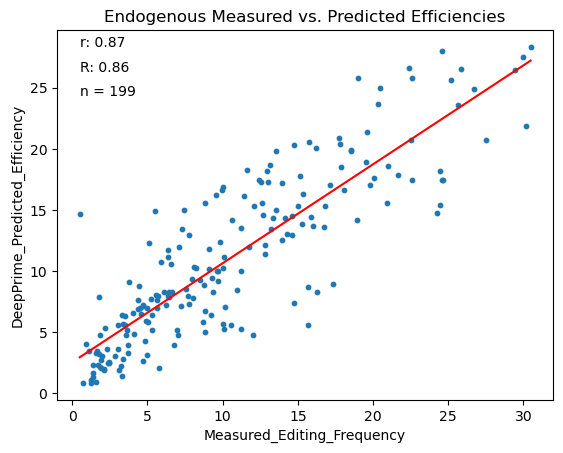

In [247]:
plt.scatter(x, y, s= 10)

# Add labels and title
plt.xlabel('Measured_Editing_Frequency')
plt.ylabel('DeepPrime_Predicted_Efficiency')
plt.title('Endogenous Measured vs. Predicted Efficiencies')
# plt.legend(title='Gene', loc = 'lower right')



plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color='red', label='Regression Line (Pearson)')


plt.text(min(x), max(y), f"r: {pearson_corr:.2f}", fontsize=10)

# Annotate Spearman correlation coefficient
plt.text(min(x), max(y)-2, f"R: {spearman_corr:.2f}", fontsize=10)

plt.text(min(x), max(y)-4, "n = "+ str(len(concatenated)), fontsize=10)


# Show the plot
plt.show()

In [249]:
#Now, calculate correlations by gene and for the overall dataset

genes = list(concatenated['gene'].unique())
print(genes)

gene_correlations = pd.DataFrame()


for g in genes:
        
    
    subset = concatenated.loc[concatenated['gene'] == g]
    print(g, len(subset))

                           
    x_sub = subset['Measured_PE_efficiency']
    y_sub = subset['DeepPrime_score']
    
    # print(g, x_sub.mean())
    

                           
    pearson_corr, pearson_p_value = pearsonr(x_sub, y_sub)
    spearman_corr, spearman_p_value = spearmanr(x_sub, y_sub)

                           
    if g not in gene_correlations:

        gene_correlations[g] = [0,0]
        gene_correlations[g] = pearson_corr
        gene_correlations[g][1] = spearman_corr
        
    else:
        gene_correlations[g][0] = pearson_corr
        gene_correlations[g][1] = spearman_corr
        

gene_correlations.index = ['Pearson','Spearman']
print(gene_correlations) 

['VEGFA', 'HEK3', 'RNF2', 'FANCF', 'HEK4', 'EMX1', 'DNMT1', 'RUNX1']
VEGFA 24
HEK3 27
RNF2 23
FANCF 28
HEK4 24
EMX1 25
DNMT1 24
RUNX1 24
             VEGFA      HEK3      RNF2     FANCF      HEK4      EMX1  \
Pearson   0.785952  0.864794  0.873871  0.493002  0.812509  0.791822   
Spearman  0.808696  0.823691  0.879387  0.507737  0.710309  0.796692   

             DNMT1     RUNX1  
Pearson   0.526675  0.861429  
Spearman  0.629565  0.822609  


<Figure size 640x480 with 0 Axes>

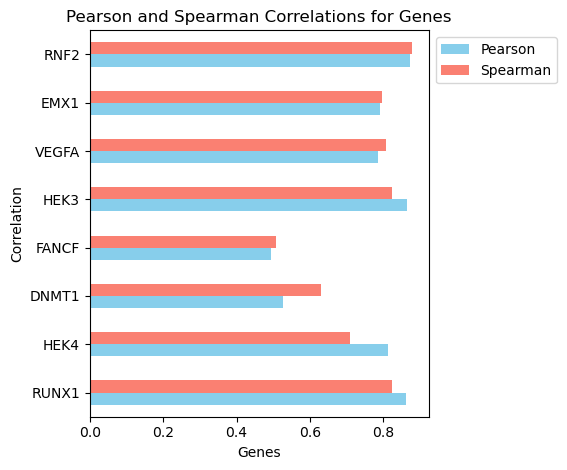

In [241]:
# Plot the bar chart

gene_correlations_t = gene_correlations.transpose()   #Transposed dataframe
# genes_order = genes[::-1]
genes_order = ['RNF2','EMX1', 'VEGFA','HEK3', 'FANCF', 'DNMT1', 'HEK4', 'RUNX1'][::-1]
gene_correlations_t = gene_correlations_t.loc[genes_order]




# Show the plot
plt.tight_layout()
plt.show()
ax = gene_correlations_t.plot(kind='barh', rot=0, color=['skyblue', 'salmon'])

# Set labels and title
ax.set_xlabel('Genes')
ax.set_ylabel('Correlation')
ax.set_title('Pearson and Spearman Correlations for Genes')
plt.legend(loc='upper right', bbox_to_anchor=(1.4, 1))

# Show the plot
plt.tight_layout()
plt.show()

0.8664822392152122 0.8620989352475041


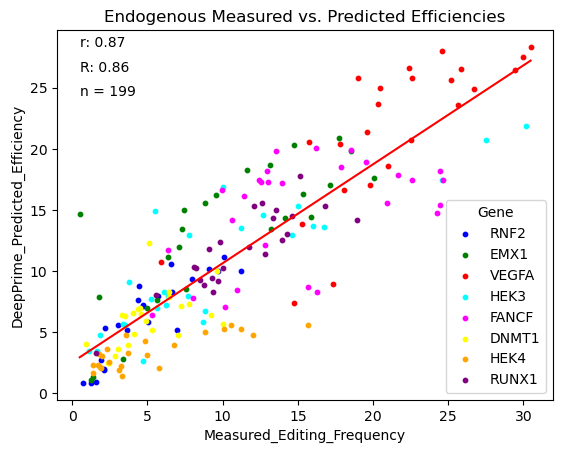

In [254]:
color_mapping = {
    'RNF2': 'blue',
    'EMX1': 'green',
    'VEGFA': 'red',
    'HEK3': 'cyan',
    'FANCF': 'magenta',
    'DNMT1': 'yellow',
    'HEK4': 'orange',
    'RUNX1': 'purple'
}


# plt.scatter(x, y, s= 0.5, alpha=0.5)

x = concatenated['Measured_PE_efficiency']
y = concatenated['DeepPrime_score']
                           
pearson_corr, pearson_p_value = pearsonr(x, y)
spearman_corr, spearman_p_value = spearmanr(x, y)

for gene, color in color_mapping.items():
    plt.scatter(x[concatenated['gene'] == gene], y[concatenated['gene'] == gene], 
                s=10, c=color, label=gene)

print(pearson_corr, spearman_corr)

# Add labels and title
plt.xlabel('Measured_Editing_Frequency')
plt.ylabel('DeepPrime_Predicted_Efficiency')
plt.title('Endogenous Measured vs. Predicted Efficiencies')
plt.legend(title='Gene', loc = 'lower right')




plt.plot(np.unique(x), np.poly1d(np.polyfit(x, y, 1))(np.unique(x)), color='red', label='Regression Line (Pearson)')


plt.text(min(x), max(y), f"r: {pearson_corr:.2f}", fontsize=10)

# Annotate Spearman correlation coefficient
plt.text(min(x), max(y)-2, f"R: {spearman_corr:.2f}", fontsize=10)

plt.text(min(x), max(y)-4, "n = "+ str(len(concatenated)), fontsize=10)


# Show the plot
plt.show()